# SCNIEC+

This notebook runs the SCENIC+ framework for unpaired scRNA-seq and scATAC-seq on the tumor cells from the Spermatogenesis Mouse dataset 

In [1]:
#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
sys.path.append('/home/sussmanj/miniconda3/envs/scenicplus/lib/')
_stderr = sys.stderr
null = open(os.devnull,'wb')

%matplotlib inline

In [2]:
import importlib
import sys
import os 
import scanpy as sc
from scipy.io import mmread
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from scenicplus.scenicplus_class import SCENICPLUS, create_SCENICPLUS_object
from scenicplus.loom import *
from scenicplus.preprocessing.filtering import *
from pycisTopic.cistopic_class import *
from pycisTopic.lda_models import evaluate_models
from pycisTopic.clust_vis import run_umap
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
import itertools
import anndata
import pickle
import dill
from pycisTopic.clust_vis import *
from pycisTopic.topic_binarization import *
from pycisTopic.diff_features import *
from pycisTopic.lda_models import run_cgs_models_mallet
import scipy.sparse as sp
import scipy.io as spio
import pyranges as pr
import numpy as  np
from pycistarget.utils import region_names_to_coordinates
from pycisTopic.lda_models import run_cgs_models
from scenicplus.wrappers.run_pycistarget import run_pycistarget
import pybiomart as pbm
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
from scenicplus.eregulon_enrichment import score_eRegulons
import seaborn as sns
from scenicplus.plotting.dotplot import heatmap_dotplot
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
from scenicplus.RSS import *
from scenicplus.plotting.correlation_plot import *
from pycisTopic.diff_features import find_highly_variable_features
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
import seaborn as sns
import sklearn
from scenicplus.differentiation_potential import *

/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-14 11:52:11,392	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Generate cisTopic object from ATAC counts matrix and save to file 

In [6]:
#Create cisTopic object from the counts matrix 
sparse_csr_matrix=spio.mmread('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/BALL_Metacells_Sparse.mtx').tocsr()
cell_list = []
region_list = [] 

with open("/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/BALL_Metacells_Cell_Names.txt", "r") as file:
    cell_list = [line.strip() for line in file]
with open("/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/BALL_Metacells_Region_Names.txt", "r") as file:
    region_list = [line.strip() for line in file]
region_list = [s.replace('-', ':', 1) for s in region_list]

path_to_blacklist='/mnt/isilon/tan_lab/sussmanj/Single_Cell_Tools/ScenicPlus/Genome_Files/hg38-blacklist.v2.bed'

In [7]:
cistopic_obj = create_cistopic_object(fragment_matrix=sparse_csr_matrix, cell_names=cell_list, region_names=region_list,
                                      path_to_blacklist=path_to_blacklist)

2024-07-24 21:15:20,336 cisTopic     INFO     Removing blacklisted regions
2024-07-24 21:15:22,446 cisTopic     INFO     Creating CistopicObject
2024-07-24 21:15:29,602 cisTopic     INFO     Done!


In [9]:
#Add cell metadata
cell_data =  pd.read_csv('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/BALL_Metacells_Metadata.txt', sep='\t')
cell_data.index = cell_list
cistopic_obj.add_cell_data(cell_data)

In [10]:
#Save cisTopic object
pickle.dump(cistopic_obj, open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/BALL_Metacells_ATAC_cistopic_obj.pkl', 'wb'))

In [11]:
#Check the cisTopic object
print(cistopic_obj)

CistopicObject from project cisTopic with n_cells × n_regions = 48271 × 307889


Load in the cisTopic object and perform topic modeling

In [3]:
#Load cisTopic object
cistopic_obj = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/BALL_Metacells_ATAC_cistopic_obj.pkl', 'rb'))
print(cistopic_obj)

CistopicObject from project cisTopic with n_cells × n_regions = 13022 × 125493


GO RUN MODELS

In [7]:
#Load models from individual files 
models = []
for file in os.listdir('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/BALL_Models/'):
   if file.endswith(".pkl"):
      model = pickle.load(open(os.path.join('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/BALL_Models/', file), "rb"))
      models.append(model)

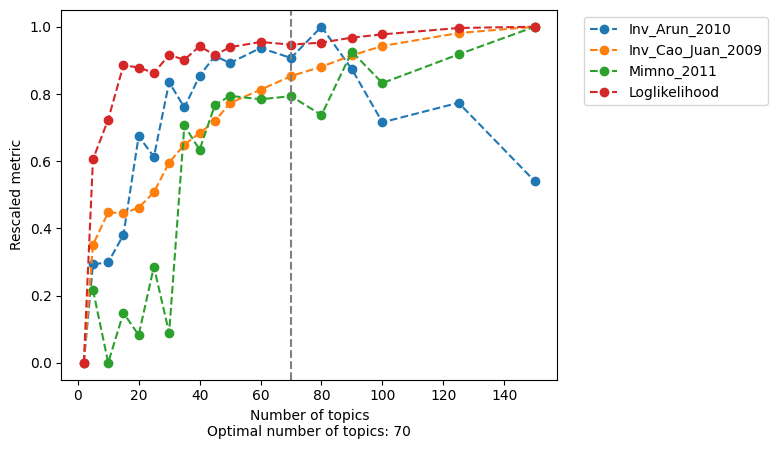

In [9]:
numTopics = 70
model = evaluate_models(models,
                     select_model = numTopics,
                     return_model = True,
                     metrics = ['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                     plot_metrics = False)

In [10]:
#Add model to cisTopic object and save again 
cistopic_obj.add_LDA_model(model)
pickle.dump(cistopic_obj,
            open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/BALL_Metacells_ATAC_cistopic_obj_with_model.pkl', 'wb'))

In [11]:
#Run UMAP
run_umap(cistopic_obj, target = 'cell', scale = True)

2024-11-14 12:00:49,744 cisTopic     INFO     Running UMAP


/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


Visualization

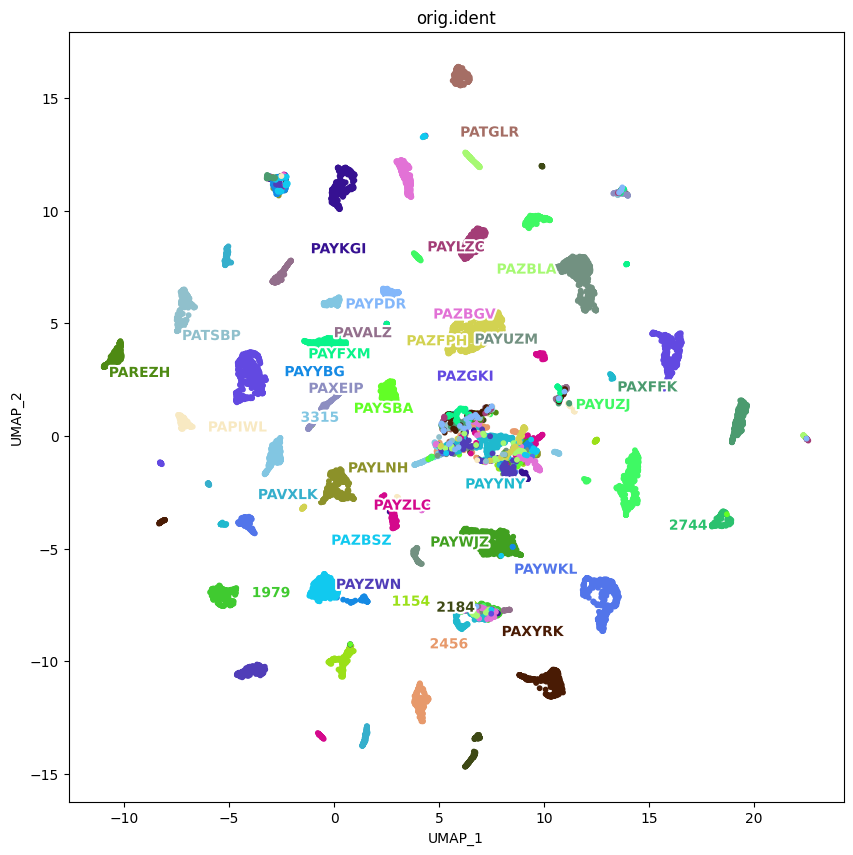

2024-11-14 12:02:31,669 fontTools.subset INFO     maxp pruned
2024-11-14 12:02:31,679 fontTools.subset INFO     cmap pruned
2024-11-14 12:02:31,686 fontTools.subset INFO     kern dropped
2024-11-14 12:02:31,686 fontTools.subset INFO     post pruned
2024-11-14 12:02:31,689 fontTools.subset INFO     FFTM dropped
2024-11-14 12:02:31,692 fontTools.subset INFO     GPOS pruned
2024-11-14 12:02:31,695 fontTools.subset INFO     GSUB pruned
2024-11-14 12:02:31,699 fontTools.subset INFO     glyf pruned
2024-11-14 12:02:31,700 fontTools.subset INFO     Added gid0 to subset
2024-11-14 12:02:31,701 fontTools.subset INFO     Added first four glyphs to subset
2024-11-14 12:02:31,702 fontTools.subset INFO     Closing glyph list over 'GSUB': 23 glyphs before
2024-11-14 12:02:31,702 fontTools.subset INFO     Glyph names: ['.notdef', '.null', 'A', 'M', 'P', 'U', 'd', 'e', 'five', 'g', 'i', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 'space', 't', 'two', 'underscore', 'zero']
2024-11-14 1

In [13]:
plot_metadata(
    cistopic_obj,
    reduction_name = 'UMAP',
    variables = ['orig.ident'],
    figsize = (10, 10), 
    save = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Figures/BALL_UMAP_CisTopics.jpg")

In [14]:
plot_topic(cistopic_obj, reduction_name = 'UMAP', num_columns = 7, 
           save = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Figures/BALL_CisTopics.png")

Inferring candidate enhancer regions

In [15]:
#Binarize topics, using the 'otsu' method
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu')
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3000)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
#Calculating DARs per cell type 
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)

2024-11-14 12:03:46,637 cisTopic     INFO     Imputing region accessibility
2024-11-14 12:03:46,638 cisTopic     INFO     Impute region accessibility for regions 0-20000
2024-11-14 12:03:47,940 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2024-11-14 12:03:49,223 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2024-11-14 12:03:50,504 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2024-11-14 12:03:51,785 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2024-11-14 12:03:53,071 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2024-11-14 12:03:54,370 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2024-11-14 12:03:54,730 cisTopic     INFO     Done!


In [22]:
markers_dict = find_diff_features(cistopic_obj, imputed_acc_obj, variable='predicted.celltype_refmap', split_pattern = '-', adjpval_thr=0.05, log2fc_thr=np.log2(1.5), n_cpu=2)

2024-11-14 12:46:26,445	INFO worker.py:1724 -- Started a local Ray instance.


2024-11-14 12:46:27,078 cisTopic     INFO     Subsetting data for CLP (3438 of 13022)
2024-11-14 12:46:28,818 cisTopic     INFO     Computing p-value for CLP
2024-11-14 12:47:15,652 cisTopic     INFO     Computing log2FC for CLP
2024-11-14 12:47:16,822 cisTopic     INFO     CLP done!
2024-11-14 12:47:16,839 cisTopic     INFO     Subsetting data for CyclingDP (10 of 13022)
2024-11-14 12:47:18,280 cisTopic     INFO     Computing p-value for CyclingDP
2024-11-14 12:48:01,719 cisTopic     INFO     Computing log2FC for CyclingDP
2024-11-14 12:48:02,874 cisTopic     INFO     CyclingDP done!
2024-11-14 12:48:02,891 cisTopic     INFO     Subsetting data for DC-Progenitor (263 of 13022)
2024-11-14 12:48:04,349 cisTopic     INFO     Computing p-value for DC-Progenitor
2024-11-14 12:48:48,610 cisTopic     INFO     Computing log2FC for DC-Progenitor
2024-11-14 12:48:49,771 cisTopic     INFO     DC-Progenitor done!
2024-11-14 12:48:49,787 cisTopic     INFO     Subsetting data for ETP (17 of 13022)


In [18]:
#Save results 
pickle.dump(region_bin_topics_otsu, open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/BALL_region_bin_topics_otsu.pkl', 'wb'))
pickle.dump(region_bin_topics_top3k, open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/BALL_region_bin_topics_top3k.pkl', 'wb'))

In [24]:
pickle.dump(markers_dict, open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/BALL_markers_dict.pkl', 'wb'))

In [25]:
#Load results 
region_bin_topics_otsu = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/BALL_region_bin_topics_otsu.pkl', 'rb'))
region_bin_topics_top3k = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/BALL_region_bin_topics_top3k.pkl', 'rb'))
markers_dict = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/BALL_markers_dict.pkl', 'rb'))

In [26]:
markers_dict

{'CLP':                             Log2FC  Adjusted_pval Contrast
 chr2:50065884-50066084    3.348698   1.158309e-05      CLP
 chr5:137598324-137598725  3.244256   4.421351e-86      CLP
 chr8:109018843-109019279  3.219008  4.170318e-173      CLP
 chrX:35670855-35671055    3.140032   2.939835e-64      CLP
 chr14:97682448-97682692   3.111570   1.089771e-29      CLP
 ...                            ...            ...      ...
 chr5:107631839-107632071  0.584993  1.575362e-111      CLP
 chr18:47945334-47945791   0.584985  7.305948e-153      CLP
 chr11:2794128-2794585     0.584975   0.000000e+00      CLP
 chr7:1425630-1425881      0.584972   1.037876e-35      CLP
 chr16:57091444-57091675   0.584963   0.000000e+00      CLP
 
 [21123 rows x 3 columns],
 'CyclingDP':                              Log2FC  Adjusted_pval   Contrast
 chr6:77368613-77368866     4.324740       0.000041  CyclingDP
 chr6:124054108-124054369   3.988075       0.000041  CyclingDP
 chr10:131420101-131420533  3.598138      

In [27]:
out_dir = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus"
os.makedirs(os.path.join("/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus", "BALL_region_sets"), exist_ok = True)
os.makedirs(os.path.join("/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus", "BALL_region_sets", "Topics_otsu"), exist_ok = True)
os.makedirs(os.path.join("/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus", "BALL_region_sets", "Topics_top_3k"), exist_ok = True)
os.makedirs(os.path.join("/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus", "BALL_region_sets", "DARs_cell_type"), exist_ok = True)

In [28]:
for topic in region_bin_topics_otsu:
    region_names_to_coordinates(
        region_bin_topics_otsu[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "BALL_region_sets", "Topics_otsu", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )

In [29]:
for topic in region_bin_topics_top3k:
    region_names_to_coordinates(
        region_bin_topics_top3k[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "BALL_region_sets", "Topics_top_3k", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )

In [30]:
for cell_type in markers_dict:
    # Replace slashes with '0-' in the cell_type name
    sanitized_cell_type = cell_type.replace('/', '-')
    
    if markers_dict[cell_type].index.empty:
        # Create an empty file
        file_path = os.path.join(out_dir, "BALL_region_sets", "DARs_cell_type", f"{sanitized_cell_type}.bed")
        with open(file_path, 'w') as f:
            pass
    else:
        df = region_names_to_coordinates(markers_dict[cell_type].index)
        if not df.empty:
            df = df.sort_values(["Chromosome", "Start", "End"])
            file_path = os.path.join(out_dir, "BALL_region_sets", "DARs_cell_type", f"{sanitized_cell_type}.bed")
            df.to_csv(
                file_path,
                sep="\t",
                header=False,
                index=False
            )

Save RNA to anndata format 

In [31]:
#Load RNA data
path_to_loom = '/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/BALL_Metacells_RNA.loom'
rna_anndata = sc.read_loom(path_to_loom)

In [32]:
rna_anndata.obs["predicted.celltype_refmap"]

CellID
1154_0_2                       Pre-B
1154_0_4                       Pre-B
1154_0_5                       Pre-B
1154_0_8                       Pre-B
1154_0_9                       Pre-B
                         ...        
PAYPDR_T/NK_21    alpha-beta(mature)
PAYPDR_T/NK_22                    NK
PAYPDR_T/NK_23                    NK
PAYPDR_T/NK_24                    NK
PAYPDR_T/NK_25    alpha-beta(mature)
Name: predicted.celltype_refmap, Length: 13022, dtype: object

In [33]:
rna_anndata.raw = rna_anndata
rna_anndata.write("/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/BALL_Metacells_RNA.h5ad")

... storing 'orig.ident' as categorical
... storing 'predicted.celltype_refmap' as categorical
... storing 'predicted.celltypegeneral_refmap' as categorical
... storing 'predicted.m.traj.ptime' as categorical
... storing 'predicted.t.traj.ptime' as categorical
... storing 'predicted.trajectory' as categorical


In [34]:
rna_anndata

AnnData object with n_obs × n_vars = 13022 × 37220
    obs: 'nCount_ATAC', 'nCount_RNA', 'nFeature_ATAC', 'nFeature_RNA', 'orig.ident', 'predicted.celltype_refmap', 'predicted.celltype_refmap.score', 'predicted.celltypegeneral_refmap', 'predicted.celltypegeneral_refmap.score', 'predicted.m.traj.ptime', 'predicted.m.traj.ptime.score', 'predicted.t.traj.ptime', 'predicted.t.traj.ptime.score', 'predicted.trajectory', 'predicted.trajectory.score'